In [437]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon 

In [438]:
class BuckleyLev():
    
    def __init__(self):
        self.params = {
            #non wetting phase viscosity
            "viscosity_o": 1.e-3,
            #wetting phase viscosity
            "viscosity_w": 1.e-3,
            #initial water sat
            "initial_sw":0.2,
            #residual water saturation,
            "residual_w":0.5,
            #residual oil saturation,
            "residual_o":0.3,
            #water rel perm at water curve end point
            "krwe":1,
            #oil rel perm at oil curve end point
            "kroe": 0.99
        }

In [439]:
def k_rw(self,sw):
    #water relative perm calculation for a given water saturation 
    p = 11.174
    return ((self.params['krwe']))*sw**p

BuckleyLev.k_rw = k_rw

In [440]:
def k_rn(self,sw):
    #oil relative perm calculation for a given water saturation 
    q = 3.326
    return ((1.-self.params['kroe']*sw)**q)

BuckleyLev.k_rn = k_rn

In [441]:
def fractional_flow(self,sw):
    #returns the fractional flow
    
    return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))

BuckleyLev.fractional_flow = fractional_flow

In [442]:
def fractional_flow_deriv(self,sw):
    #calculate derivative of fractional flow - dFw/dSw - Vsh
    
    f_deriv = (self.fractional_flow(sw+0.0001) - self.fractional_flow(sw))/0.0001
    
    return f_deriv

BuckleyLev.fractional_flow_deriv = fractional_flow_deriv

In [443]:
def plot_fractional_flow_deriv(self):
    #plot the derivative dFw/dSw - Vsh vs Sw
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y ]
    
    plt.plot(x,y)
    plt.title('Derivative of fractional flow curve')
    plt.xlabel('dfw/dSw')
    plt.ylabel('Sw')
    plt.show()
    
BuckleyLev.plot_fractional_flow_deriv=plot_fractional_flow_deriv

In [444]:
def sw_at_shock_front(self):
    #first find range to search in by looking where 2nd derivative is negative (where curve turns)
    
    sw_start = 1.-self.params['residual_o']
    sw_end = self.params['residual_w']
    
    
    for sw in np.arange(self.params['residual_w']+1.e-9, 1.-self.params['residual_o'],0.001):
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw < sw_start):
            #i.e. we are below sw_start and the grad is negative - update upper limit
            sw_start = sw
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw > sw_end):
            # i.e. we are above sw_end and the gradient is negative - update lower limit
            sw_end = sw
        else:
            sw_at_front = 0.
            current_min = 1000.
        
            #find where finite difference approximation (almost) equals the continuous value of the function
    for sw in np.arange(sw_start,sw_end, 0.0001):
        
        current_diff = abs(self.fractional_flow_deriv(sw)-self.fractional_flow(sw)/sw)
        #print( 'grad func',self.fractional_flow_deriv(sw),sw,self.fractional_flow(sw)/sw)
        print('approx',self.fractional_flow(sw)/sw, sw)
        if current_diff < current_min:
            #print('sw at front',current_min, sw,current_diff)
            current_min = current_diff
            sw_at_front = sw
                
            current_min = current_diff
                    
    return sw_at_front
BuckleyLev.sw_at_shock_front = sw_at_shock_front

In [480]:
def plot_fractional_flow(self):
    #plot the sw vs fractional flow
    
    #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
    x = np.linspace(self.params["residual_w"]+1e-3,(1),100)
    y = [self.fractional_flow(i) for i in x ]
    
    plt.plot(x,y)
    
    #sw_at_front = self.sw_at_shock_front()
    #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')
    
    plt.title('Fractional flow as a function of water saturation')
    plt.xlabel('Sw')
    plt.ylabel('Fractional flow')
    plt.ylim([0,1.1])
    plt.xlim([0,1])
    
    #add limiting fractional flow lines
    plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
    plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))
    
    
    plt.show()
    print(y[len(y)-1])
    
BuckleyLev.plot_fractional_flow = plot_fractional_flow

In [446]:
def fractional_flow_2deriv(self,sw):
    f_2deriv = ((self.fractional_flow(sw+0.01))-2*(self.fractional_flow(sw))-self.fractional_flow(sw-0.01))/((0.01)**2)
    return f_2deriv

BuckleyLev.fractional_flow_2deriv = fractional_flow_2deriv

In [447]:
a = BuckleyLev()
#a.plot_fractional_flow()
#a.plot_fractional_flow_deriv()
#a.sw_at_shock_front()


In [521]:
def displacement_plot(self):
    #using the shock front velocity, plot the displacement profile
    v_sh = self.sw_at_shock_front()
    
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y if self.fractional_flow_deriv(i)>v_sh ]
   

    return x
BuckleyLev.displacement_plot = displacement_plot

In [ ]:
a.displacement_plot()

In [519]:
def rarefaction_plot(self):
    # it should calculate the shock velocity and the corresponding saturation which this occurs an
    
    #create dx window of increasing size for calculating welge
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    
    maximum, sw_shock = 0,0
    grads = []
    
    ## calculate welge gradient at each point until we find the max = shock velocity
    for swi in x:
        grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
        grads.append(grad)
        
        if grad>maximum:
            sw_shock = swi
            maximum = grad
            
    #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
    #plus one to include the actual shock velocity. Reverse to get the values in the right order
    rarefaction = (grads[:([i for i,j in enumerate(grads) if j == maximum][0]+1)])
    rarefaction.sort(reverse=True)

    y = x[:(len(rarefaction))]
    
    #plot rarefaction part 
    plt.plot(rarefaction,y,'b',lw=2)
    
    #highlight vshock point
    plt.plot(rarefaction[0],y[0],'ro')
    
    #add the part ahead of the shock front
    plt.vlines(rarefaction[0],y[0],self.params["initial_sw"],'b',lw=2)
    plt.hlines(self.params["initial_sw"],rarefaction[0],rarefaction[0]+1,'b',lw=2)

    #add saturation lines
    plt.hlines(self.params["initial_sw"],0,rarefaction[0],linestyles='dashed',lw=2,colors='0.4')
    plt.hlines(y[0],0,rarefaction[0],linestyles='dashed',lw=2, colors='0.4')
    plt.vlines(rarefaction[0],-2,self.params["initial_sw"],linestyles='dashed',lw=2, colors='0.4')

    # add annotations
    plt.annotate('V shock',xy=(rarefaction[0]+0.02,y[0]+0.02))
    plt.annotate('Sw f',xy=(0+0.04,y[0]-0.05))
    plt.annotate('Sw i',xy=(0+0.04,self.params["initial_sw"]-0.05))
    
    
    #ad vdmin if the min velocity values is not zero 
    if (rarefaction[len(rarefaction)-1]>0.001):
        plt.hlines(y[len(y)-1],0,rarefaction[len(rarefaction)-1],'b',lw=2)
        plt.plot(rarefaction[len(rarefaction)-1],y[len(y)-1],'ro')
        plt.annotate('V min',xy=((rarefaction[len(rarefaction)-1]+0.08),(y[len(y)-1])))
        plt.vlines(rarefaction[len(rarefaction)-1],y[len(y)-1],0,linestyles='dashed',lw=2, colors='0.4')
        plt.annotate('Sw c',xy=(0+0.04,1-self.params["residual_o"]+0.03))

    plt.xlabel('Dimensionless Velocity, Vd = xd/td')
    plt.ylabel('Saturation')
    
    plt.ylim([0,1])
    plt.xlim([0,rarefaction[0]+1])
    plt.title('Saturation profile velocity')
    plt.show()
    
    
BuckleyLev.rarefaction_plot = rarefaction_plot

0.99800376989047002

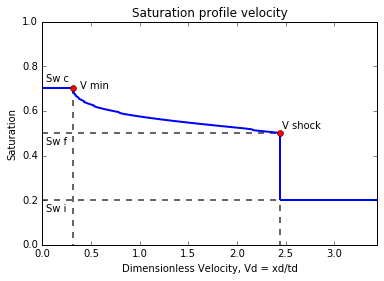

In [520]:
a = BuckleyLev()
a.rarefaction_plot()

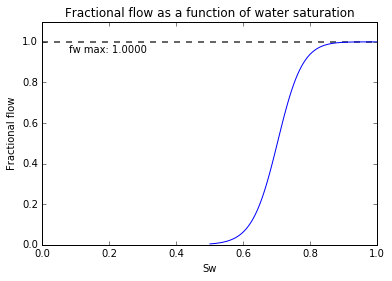

0.999999777157


In [481]:
a.plot_fractional_flow()

41